In [35]:
import torch
# choosing gpu as computational device if gpu is available
# since we are working with small data this step is not necessary indeed
# but i own the repo and do whatever i want... just joking doing it for fun im really stressed out


# MPS: Metal Performance Shaders --> for Mac devices with M chips
# CUDA: For device with cuda support
# CPU: General case

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
generator = torch.Generator(device=device)
seed = 20040324
generator.manual_seed(seed)

import pandas as pd

# # Read the CSV file
# df = pd.read_csv('/Users/ezelbayraktar/Documents/DL-NLP/MyLanguageModelJourney/OPTED-Dictionary.csv')

# # Get the first column
# first_column = df.iloc[:, 0]

# # Convert the first column to text
# first_column_text = "\n".join(first_column.astype(str))

# print(first_column_text)

read_file = open('/Users/ezelbayraktar/Documents/DL-NLP/MyLanguageModelJourney/names.txt', 'r')
words = read_file.read().splitlines()
read_file.close()

In [36]:
#getting chars 
chars = sorted(list(set(''.join(words))))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [37]:
## implementing a dictionary to enum chars
ctoi={}
ctoi['.'] = 0
i = 1
for char in chars:
    # i do not check if char is in ctoi since chars is already a set so no dupes
    # so it is not possible that char is added to ctos twice
    ctoi[char] = i
    i+=1
ctoi['.']

0

In [38]:
## implementing a dictionary to char nums

## just flipping ctoi since itoc is just the same but with keys and values exchanged
itoc = {value: key for key, value in ctoi.items()}
itoc[0]

'.'

In [39]:
## building ...
import torch
gram = 3
X,Y = [],[]
for w in words:
    #print(w)
    grams = [0]*gram
    for ch in w+'.':
        cai = ctoi[ch] ## cai stands for character as integer
        X.append(grams)
        Y.append(cai)
        #print(itoc[grams[0]],itoc[grams[1]],itoc[grams[2]]," >> ",itoc[cai])
        ##print(ch,cai)
        grams = grams[1:] + [cai]

X = torch.tensor(X,device=device)
Y = torch.tensor(Y,device=device)

In [40]:
data_size = X.shape[0]
data_random_indices = torch.randperm(data_size)
data_random_indices

tensor([ 32979, 147050,  23279,  ...,  77720, 185955, 132601])

In [41]:
train_size = 0.85
#train_indices_of_rows = torch.randint(0, data_size ,data_size * train_size, generator=generator)
train_indices_of_rows = data_random_indices[:int(train_size*data_size)]
X_train = X[train_indices_of_rows]
Y_train = Y[train_indices_of_rows]

In [42]:
validation_size = 0.1
#validation_indices_of_rows = torch.randint(0, data_size ,data_size * validation_size, generator=generator)
validation_indices_of_rows = data_random_indices[int(train_size*data_size):int((validation_size+train_size)*data_size)]
X_valid = X[validation_indices_of_rows]
Y_valid = Y[validation_indices_of_rows]

In [43]:
evaluation_size = 0.1
#evalutation_indices_of_rows = torch.randint(0, data_size ,data_size * evaluation_size, generator=generator)
evalutation_indices_of_rows = data_random_indices[int((validation_size+train_size)*data_size):]
X_eval = X[evalutation_indices_of_rows]
Y_eval = Y[evalutation_indices_of_rows]

In [44]:

# Print shapes
print("Shapes:")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_valid: {X_valid.shape}")
print(f"Y_valid: {Y_valid.shape}")
print(f"X_eval: {X_eval.shape}")
print(f"Y_eval: {Y_eval.shape}")



Shapes:
X_train: torch.Size([193924, 3])
Y_train: torch.Size([193924])
X_valid: torch.Size([22814, 3])
Y_valid: torch.Size([22814])
X_eval: torch.Size([11408, 3])
Y_eval: torch.Size([11408])


In [45]:
# X_train = X_train.to(device)
# Y_train = Y_train.to(device)
# X_valid = X_valid.to(device)
# Y_valid = Y_valid.to(device)
# X_eval = X_eval.to(device)
# Y_eval = Y_eval.to(device)



rows = len(chars) + 1 #  english chars + the dot
dimension = 15 # dimensions for each char
dimensions = torch.randn((rows, dimension), generator=generator, device=device)
#dimensions = torch.randn((27, 10), generator=generator, device=device, requires_grad=True)

dimensions.shape
# params are the dimension values our model assigns to characters

torch.Size([27, 15])

In [46]:
dimensions[X].shape

torch.Size([228146, 3, 15])

In [47]:
# here we still have the gram table actually but each character in each gram is repsrented with dimenstional params
#->> dimensions[X]
embedded = dimensions[X] 
embedded.shape

torch.Size([228146, 3, 15])

In [48]:
inputNumberLayer1 = (embedded.shape)[2]*(embedded.shape)[1] # input nummber is equal to (grams count) * (dimensions)


neuronsLayer1 = 200 # matter of choice CAUTION: too much neurons may cause overfitting

print(inputNumberLayer1)

y_gain = torch.ones(1,neuronsLayer1,  device=device)
y_b = torch.zeros(1,neuronsLayer1,  device=device)

model_std = torch.ones(1,neuronsLayer1,  device=device)
model_mean = torch.zeros(1,neuronsLayer1,  device=device)


W1 = torch.randn(inputNumberLayer1, neuronsLayer1, generator=generator, device=device) * ((5/3)/ (inputNumberLayer1)**0.5)
b1 = torch.randn(neuronsLayer1, generator=generator, device=device) * 0.1

W2 = torch.randn(neuronsLayer1, 27, generator=generator, device=device) * 0.1
b2 = torch.randn(27, generator=generator, device=device) * 0.1

# W3 = torch.randn(100, 27, generator=generator, device=device)
# b3 = torch.randn(27, generator=generator, device=device)

# W4 = torch.randn(140, 90, generator=generator, device=device)
# b4 = torch.randn(90, generator=generator, device=device)

# layer1 = layer(30, 200)
# layer2 = layer(200, 27)
# layers = [layer1, layer2]

45


Iteration 0: 2.158914089202881, Time: 1713432528.5979211
Iteration 1000: 2.0417773723602295, Time: 1713432533.920042
Iteration 2000: 2.1039037704467773, Time: 1713432538.876619
Iteration 3000: 2.037090539932251, Time: 1713432543.78433
Iteration 4000: 1.9025291204452515, Time: 1713432548.700497
Iteration 5000: 2.2109813690185547, Time: 1713432554.272594
Iteration 6000: 2.08143949508667, Time: 1713432558.9036632
Iteration 7000: 2.0376651287078857, Time: 1713432563.6541
Iteration 8000: 2.0048489570617676, Time: 1713432568.6479518
Iteration 9000: 2.3181304931640625, Time: 1713432573.486911
Iteration 10000: 2.1084372997283936, Time: 1713432578.503233
Iteration 11000: 2.0178911685943604, Time: 1713432583.404047
Iteration 12000: 2.1046900749206543, Time: 1713432588.682844
Iteration 13000: 2.099911689758301, Time: 1713432593.299055
Iteration 14000: 2.1365671157836914, Time: 1713432597.991478
Iteration 15000: 2.071028470993042, Time: 1713432602.724342
Iteration 16000: 2.046849012374878, Time: 1

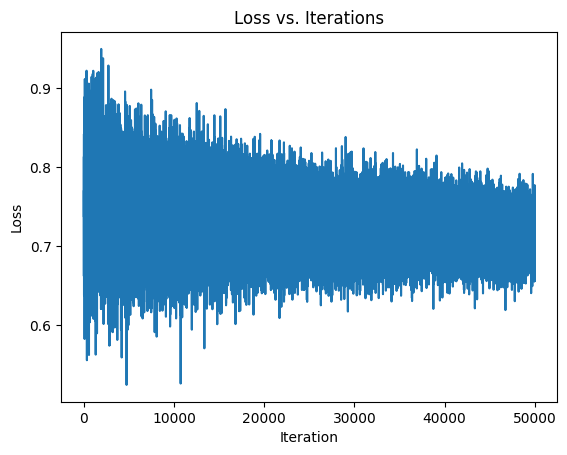

50000 iterations done. Last loss: 0.6846219897270203


In [85]:
import time
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

loss_values = []
iterations = []
dimensions = dimensions.to(device)

parameters = [W1, b1, W2, b2]
for parameter in parameters:
    parameter.requires_grad = True
parameters += [y_gain, y_b]
batch_size = 90

iters = 50000

# Training loop
for iter in range(iters):


    batch_indexes = torch.randint(0, X_train.shape[0], (batch_size,)).to(device)
    embedded = dimensions[X_train[batch_indexes]]
    embedded = embedded.view(embedded.shape[0], embedded.shape[1] * embedded.shape[2])
    
    not_activated_layer1 = embedded @ W1 + b1
    nal_mean = not_activated_layer1.mean(0, keepdim=True)
    nal_std = not_activated_layer1.std(0, keepdim=True)
    
    nal_to_normalize = y_gain * ((not_activated_layer1 - nal_mean) / nal_std) + y_b
    activation1 = torch.tanh(nal_to_normalize)

    with torch.no_grad():
        model_mean = 0.99 * model_mean + 0.01 * nal_mean
        model_std = 0.99 * model_std + 0.01 * nal_std

    # activation1 = torch.tanh(embedded @ W1 + b1)
    # activation2 = torch.tanh(activation1 @ W2 + b2)
    # activation3 = torch.tanh(activation2 @ W3 + b3)

    out = activation1 @ W2 + b2

    logits = out
    targets = Y_train[batch_indexes].to(device)
    loss = F.cross_entropy(logits, targets)
    
    # Store loss value and iteration number
    loss_values.append(loss.log().item())
    iterations.append(iter)
    
    if iter % 1000 == 0:
        print(f'Iteration {iter}: {loss.item()}, Time: {time.time()}')
        batch_size += 10
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # forward pass
    # forward pass
    lr = 0.1 if iter < iters*0.9 else 0.01

    for parameter in parameters:
        if parameter.grad is not None:
            parameter.data += -lr * parameter.grad


# Plot loss graph
plt.plot(iterations, loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.show()
print(f'{len(loss_values)} iterations done. Last loss: {loss_values[-1]}')


In [86]:

embedded = dimensions[X_eval]
embedded = embedded.view(embedded.shape[0] , embedded.shape[1]*embedded.shape[2])
activation1_raw = embedded @ W1 + b1
activation1_std = activation1_raw.std(0, keepdim=True)
activation1_mean = activation1_raw.mean(0, keepdim=True)
activation1 = torch.tanh(y_gain * ((activation1_raw - activation1_mean) / activation1_std) + y_b)
out = activation1 @ W2 + b2
logits = out
targets = Y_eval.to(device)
loss = F.cross_entropy(logits, targets)
loss

tensor(2.1178, device='mps:0', grad_fn=<NllLossBackward0>)

In [87]:

# sample from the model
for _ in range(20):
    out = []
    context = [0] * gram # initialize with all ...
    while True:
      emb = dimensions[torch.tensor([context],device=device)] # (1,block_size,d)
      emb = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2])
      emb = emb @ W1 + b1
      layer_1 = y_gain * ((emb - model_mean) / model_std) + y_b
      h = torch.tanh(layer_1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1).to('cpu')
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itoc[i] for i in out))

tie.
shute.
recnan.
emreebeadiva.
adie.
sur.
ofiyah.
drick.
kennella.
ku.
rajd.
sadity.
ina.
roreyah.
laurie.
zyyah.
rael.
mina.
baalayton.
sey.


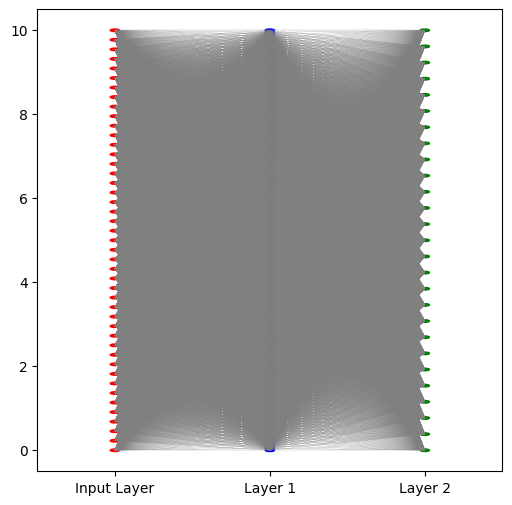

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axis
fig, ax = plt.subplots(1,1,figsize=(6,6))
circles = []
lines = []

# Number of neurons in each layer
input_neurons = inputNumberLayer1
layer1_neurons = neuronsLayer1
output_neurons = 27

# Scaling factors for the y-coordinates
input_scale = 10
layer1_scale = 10
output_scale = 10

# Create circles for each neuron
for i in range(input_neurons):
    circles.append(plt.Circle((0, i/(input_neurons-1)*input_scale), 0.03, color='r'))  # smaller radius
for i in range(layer1_neurons):
    circles.append(plt.Circle((1, i/(layer1_neurons-1)*layer1_scale), 0.03, color='b'))  # smaller radius
for i in range(output_neurons):
    circles.append(plt.Circle((2, i/(output_neurons-1)*output_scale), 0.03, color='g'))  # smaller radius

# Create lines for each connection
for i in range(input_neurons):
    for j in range(layer1_neurons):
        lines.append(plt.Line2D((0, 1), (i/(input_neurons-1)*input_scale, j/(layer1_neurons-1)*layer1_scale), color='gray', linewidth=0.2))  # thinner line
for i in range(layer1_neurons):
    for j in range(output_neurons):
        lines.append(plt.Line2D((1, 2), (i/(layer1_neurons-1)*layer1_scale, j/(output_neurons-1)*output_scale), color='gray', linewidth=0.2))  # thinner line

# Add all artists (neurons and connections) to the plot
for line in lines:
    ax.add_artist(line)
for circle in circles:
    ax.add_artist(circle)

# Set limits and labels
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, max(input_scale, layer1_scale, output_scale) + 0.5)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Input Layer', 'Layer 1', 'Layer 2'])

plt.show()